# 보팅 분류기(Voting Classifier)

In [ ]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [ ]:
# 개별 모델은 로지스틱 회귀와 KNN 임. 
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 
vo_clf = VotingClassifier( estimators=[('LR',lr_clf),('KNN',knn_clf)] , voting='soft' )

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    test_size=0.2 , random_state= 156)

# VotingClassifier 학습/예측/평가. 
vo_clf.fit(X_train , y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

# 개별 모델의 학습/예측/평가.
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train , y_train)
    pred = classifier.predict(X_test)
    class_name= classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test , pred)))

# 보팅 분류기가 더 높음 

Voting 분류기 정확도: 0.9474
LogisticRegression 정확도: 0.9386
KNeighborsClassifier 정확도: 0.9386


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


# 랜덤 포레스트

In [ ]:
import os

os.chdir("/content/drive/MyDrive/data")
print(os.getcwd())

/content/drive/MyDrive/data


In [ ]:
# 중복된 피처명에 _1 또는 _2를 추가부여해 새로운 피처명을 가지는 DataFrame을 반환하는 함수인 
# get_new_feature_name_df()를 생성

def get_new_feature_name_df(old_feature_name_df):
  feature_dup_df = pd.DataFrame(data = old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
  feature_dup_df = feature_dup_df.reset_index()
  new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how = 'outer')
  new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'-'+str(x[1]) if x[1]>0 else x[0],
                                                                                             axis=1)
  new_feature_name_df = new_feature_name_df.drop(['index'], axis = 1)
  return new_feature_name_df

In [ ]:
# 이제 train디렉터리에 있는 학습용 데이터 세트와 레이블 데이터 세트, test디렉터리에 있는 테스트용 피처 데이터 파일과 레이블 데이터
# 파일을 각각 학습/테스트용 DataFrame에 로드하겟다. 

import pandas as pd
def get_human_dataset():

  # 각 데이터 파일은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
  feature_name_df = pd.read_csv('./human_activity/features.txt', sep = '\s+', header = None, names = ['column_index', 'column_name'])

  # 중복된 피처명을 수정하는 get_new_feature_name_df()이용, 신규 피처명 DataFrame생성 
  new_feature_name_df = get_new_feature_name_df(feature_name_df)

  # DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
  feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

  # 학습 피처 데이터세트와 테스트 피처 데이터를 DataFrame으로 로딩. 칼럼명은 feature_name적용
  X_train = pd.read_csv('./human_activity/train/X_train.txt', sep='\s+', names = feature_name)
  X_test = pd.read_csv('./human_activity/test/X_test.txt', sep='\s+', names = feature_name)

  # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 칼럼명은 action으로 부여
  y_train = pd.read_csv('./human_activity/train/y_train.txt', sep='\s+', header = None, names = ['action'])
  y_test = pd.read_csv('./human_activity/test/y_test.txt', sep='\s+', header = None, names = ['action'])

  # 로드된 학습/테스트용 Dataframe을 모두 반환 
  return X_train, X_test, y_train, y_test

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset을 이용해 학습 테스트용 DataFrame반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state = 0 )
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도:{0:.4f}'.format(accuracy))

# 랜덤 포레스트는 사용자 행동 인식 데이터 세트에 대해 약 92.5% 정확도를 보여준다.

랜덤 포레스트 정확도:0.9253


## 랜덤 포레스트 하이퍼 파라미터 및 튜닝

In [ ]:
# GridSearchCV를 이용해 랜덤 포레스트의 하이퍼 파라미터를 튜닝해 보겠다.

from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100],
    'max_depth' : [6, 8, 10, 12],
    'min_samples_leaf' : [8, 12, 18],
    'min_samples_split' : [8, 16, 20]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 2, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

# n_estimators=100, max_depth = 10, min_samples_leaf = 8, min_samples_split=8일때 91.8 정확도 나옴

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9180


In [ ]:
# 이번에는 n_estimators를 300으로 증가시켜 보겠다.
rf_clf1 = RandomForestClassifier(n_estimators = 300, max_depth = 10, min_samples_leaf = 8, min_samples_split = 8, random_state = 0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도: 0.9165


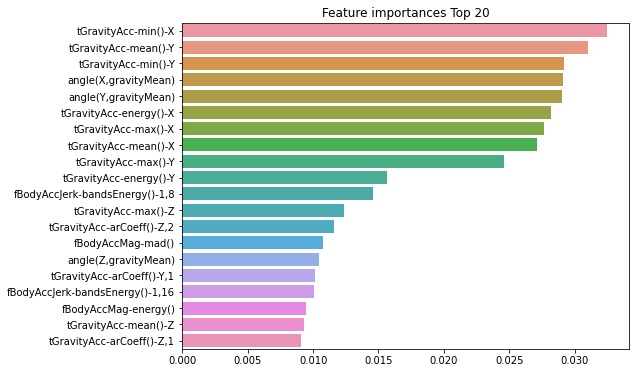

In [ ]:
# 피처의 중요도 시각화
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending = False)[:20]

plt.figure(figsize = (8, 6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y = ftr_top20.index)
plt.show()

# GBM(그래디언트 부스팅)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위함. 시작 시간 설정
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state = 0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print("GBM 정확도:{0:.4f}".format(gb_accuracy))
print("GBM 수행 시간: {0:.1f}초".format(time.time() - start_time))

# 기본 하이퍼 파라미터만으로 랜덤 포레스트보다 나은 예측 성능을 나타낸다. 

GBM 정확도:0.9386
GBM 수행 시간: 695.9초


## GBM 하이퍼 파라미터 및 튜닝

In [ ]:
# 그리드서치CV를 이용해 파라미터 최적화를 해보겠다.

params = {
    'n_estimators' : [100, 500],
    'learning_rate' : [0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf, param_grid = params, cv = 2, verbose = 1)
grid_cv.fit(X_train, y_train)
print("최적 하이퍼 파라미터:\n", grid_cv.best_params_)
print("최고 예측 정확도:{0:.4f}".format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits


In [ ]:
# GridSearchCV를 이용해 최적으로 학습된 estimator로 예측 수행.
gb_pred = grid_cv.best_estimator_.predixt(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

# XGBoost

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
print(xgb.__version__)

0.90


## XGBoost를 이용해 위스콘신 유방암 예측하기 프로젝트

### 파이썬 래퍼 XGBoost 적용

In [ ]:
# 위스콘신 유방암 데이터 세트에 기반해 종양의 다양한 피처에 따라 악성종양인지 양성종양인지를 XGBoost를 이용해 예측해 보겠다.
# 악성종양은 양성종양보다 더 심각한 종양이라고 알고 있으면 되겠다.

from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data= X_features, columns = dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [ ]:
# 타깃레이블 종류는 악성인 malignant =0, 양성인 benign = 1
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size = 0.2, random_state = 156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [ ]:
# 넘파이 형태의 학습 데이터 세트와 테스트 데이터 세트를 DMatrix로 변환하기

dtrain = xgb.DMatrix(data = X_train, label = y_train)
dtest = xgb.DMatrix(data = X_test, label = y_test)

# 하이퍼 파라미터 적용 -> 웬만하면 딕셔너리 형태로
params = { 'max_depth' : 3,
          'eta':0.1, 
          'objective':'binary:logistic',
          'eval_metric':'logloss',
          'early_stoppings':100}

num_rounds = 400

In [ ]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기한다.
wlist = [(dtrain, 'train'), (dtest, 'eval')]

# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = num_rounds, early_stopping_rounds = 100, evals = wlist)

# train()으로 학습을 수행하면 반복 시 train-erorr와 eval-logloss가 지속적으로 감소한다.

[0]	train-logloss:0.609688	eval-logloss:0.61352
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.540803	eval-logloss:0.547842
[2]	train-logloss:0.483753	eval-logloss:0.494248
[3]	train-logloss:0.434457	eval-logloss:0.447986
[4]	train-logloss:0.39055	eval-logloss:0.409109
[5]	train-logloss:0.354145	eval-logloss:0.374977
[6]	train-logloss:0.321222	eval-logloss:0.345714
[7]	train-logloss:0.292592	eval-logloss:0.320529
[8]	train-logloss:0.267467	eval-logloss:0.29721
[9]	train-logloss:0.245153	eval-logloss:0.277991
[10]	train-logloss:0.225694	eval-logloss:0.260302
[11]	train-logloss:0.207937	eval-logloss:0.246037
[12]	train-logloss:0.192184	eval-logloss:0.231556
[13]	train-logloss:0.177916	eval-logloss:0.22005
[14]	train-logloss:0.165222	eval-logloss:0.208572
[15]	train-logloss:0.153622	eval-logloss:0.199993
[16]	train-logloss:0.14333	eval-logloss:0.190118
[17]	train-logl

In [ ]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 prebs에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
print('예측 값 10개만 표시:', preds[:10])

predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
예측 값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba = None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  # ROC - AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차행렬')
  print(confusion)
  # ROC-AUC print 추가
  print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}, F1:{f1}, AUC:{roc_auc}')

In [ ]:
get_clf_eval(y_test, preds, pred_probs)

오차행렬
[[35  2]
 [ 1 76]]
정확도:0.9736842105263158, 정밀도:0.9743589743589743, 재현율:0.987012987012987, F1:0.9806451612903225, AUC:0.995085995085995


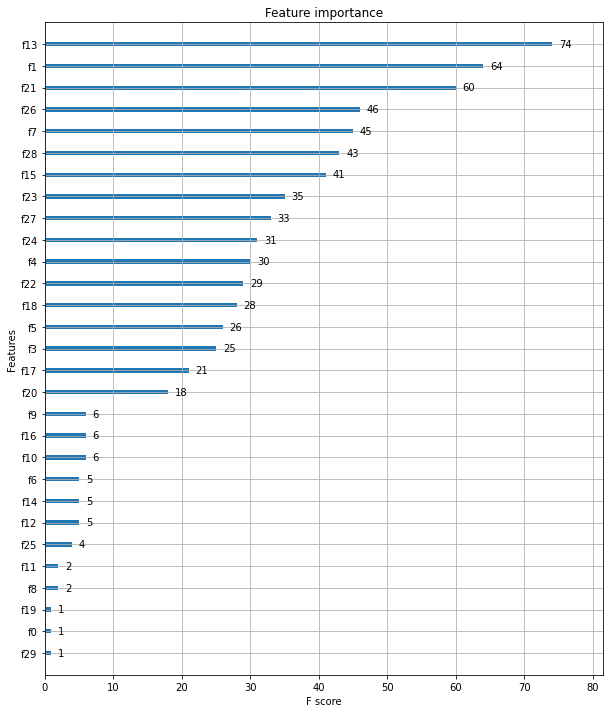

In [ ]:
# 시각화
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(xgb_model, ax = ax)

# f0은 처번째 피처, f1은 두번째 피처를 의미

### 사이킷런 래퍼 XGBoost의 개요 및 적용

In [ ]:
# 사이킷런 래퍼 XGBoost 클래스 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate= 0.1, max_depth = 3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [ ]:
# get_clf_eval()을 이용해 사이킷런 래퍼 XGBoost로 만들어진 모델의 예측 성능 평가 
# 앞 절과 동일하게 테스트 실제 레이블 값을 가지는 y_test와 예측 레이블인 w_preds를 인자로 입력

get_clf_eval(y_test, w_preds, w_pred_proba)

오차행렬
[[35  2]
 [ 1 76]]
정확도:0.9736842105263158, 정밀도:0.9743589743589743, 재현율:0.987012987012987, F1:0.9806451612903225, AUC:0.995085995085995


In [ ]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, maax_depth = 3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds= 100,
                eval_metric = 'logloss', eval_set = evals, verbose = True)
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

# n_estimators를 400으로 설정해도 400번 반복을 수행하지 않고 311번 반복한 후 학습이 완료됐다.
# 왜냐하면 211번 반복 시 logloss가 0.0855이고, 311번 반복시 0.0859이다.
# 211번에서 311번까지 early_stopping_rounds = 100으로 지정된 100번의 반복 동안 성능평가 지수가 
# 향상되지 않았기 때문에 더 이상 반복하지 않고 멈춘 것이다.


[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494248
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

In [ ]:
 # 조기 중단으로 학습된 XGBClassifier의 예측 성능을 살펴보겠다. 조기 중단이 적용되지 않은 결과보다
 # 약간 저조한 성능을 나타냈지만 큰 차이는 아니다.

 get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차행렬
[[34  3]
 [ 1 76]]
정확도:0.9649122807017544, 정밀도:0.9620253164556962, 재현율:0.987012987012987, F1:0.9743589743589742, AUC:0.9954369954369954


In [ ]:
# 조기 중단값을 너무 급격하게 줄이면 예측 성능이 저하될 우려가 크다.
# early_stopping_rounds를 10으로 하면 아직 성능이 향상될 여지가 있음에도 10번 반복하는 동안 성능 평가 지표가
# 향상되지 않으면 반복이 멈춰 버려서 충분한 학습이 되지 않아 에측 성능이 나빠질 수 있다.

# early_stopping_rounds = 10으로 설정후 예측 성능을 다시 측정해보겠다.
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, eval_metric = 'logloss', eval_set = evals, verbose = True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

# 62번 반복까지만 수행된 후 학습이 종료됐는데, 62번 반복의 logloss가 0.090이고
# 52번 반복 logloss가 0.089로 10번의 반복 동안 성능평가 지수가 향상되지 못해서 더이상 반복을 수행하지 않고
# 학습이 종료됐다. 이렇게 학습된 모델로 예측한 결과 정확도는 0.956으로 early_stopping_rounds를 100으로 설정했을때 보다
# 조금 더 낮은 수치이다.

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494248
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912


# LightGBM

In [ ]:
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size = 0.2, random_state = 156)

# 앞서 XGBoost와 동일하게 n_estimators 400 설정.
lgbm_wrapper = LGBMClassifier(n_estimators = 400)

# LightGBM도 XGBoost와 동일하게조기 중단 수행가능.
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric = 'logloss',
                 eval_set = evals, verbose = True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[1]	valid_0's binary_logloss: 0.565079	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.507451	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355846	valid_0's binary_logloss: 0.355846
[7]	valid_0's binary_logloss: 0.330897	valid_0's binary_logloss: 0.330897
[8]	valid_0's binary_logloss: 0.306923	valid_0's binary_logloss: 0.306923
[9]	valid_0's binary_logloss: 0.28776	valid_0's binary_logloss: 0.28776
[10]	valid_0's binary_logloss: 0.26917	valid_0's binary_logloss: 0.26917
[11]	valid_0's binary_logloss: 0.250954	valid_0's binary_logloss: 0.250954
[12]	valid_0's binary_logloss: 0.23847	valid_0's binary_logloss: 0.23847
[13]	valid_0's binary_logloss: 0.225865	valid_0's bi

In [ ]:
# 조기 중단으로 147번 반복까지만 수행하고 학습을 종료했다. 이제 학습된 LightGBM 모델을 기반으로
# 예측 성능을 평가해보겠다.

get_clf_eval(y_test, preds, pred_proba)

오차행렬
[[33  4]
 [ 2 75]]
정확도:0.9473684210526315, 정밀도:0.9493670886075949, 재현율:0.974025974025974, F1:0.9615384615384615, AUC:0.9926289926289926


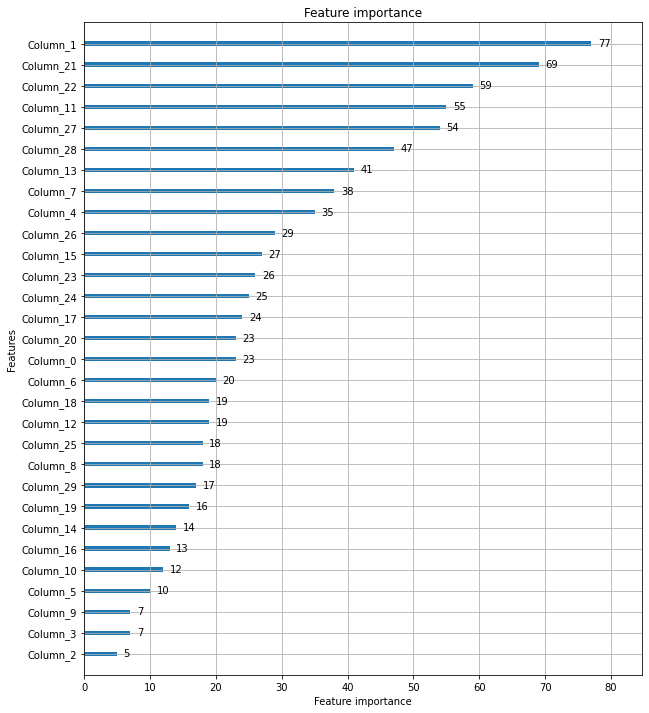

In [ ]:
# 시각화
# plot_importance()를 이용해 피처 중요도 시각화

from lightgbm import plot_importance
import matplotlib.pyplot as plt

flg, ax = plt.subplots(figsize = (10, 12))
plot_importance(lgbm_wrapper, ax = ax)

# 분류 실습 - 캐글 산탄데르 고객 만족 예측

- 모델의 성능 평가는 ROC-AUC(ROC 곡선 영역)로 평가한다. 대부분이 만족(TARGET=0)이고 불만족인(TARGET=1) 데이터는 일부일 것이기 때문에 정확도 수치보다는 ROC-AUC가 더 적합하다.

## .1. 데이터 전처리

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv('train_santander.csv', encoding = 'latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

# 클래스 값 칼럼을 포함한 피처가 371개 존재

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [ ]:
# 피처의 타입과 Null값 알아보기
cust_df.info()

# 186개의 피처가 float형, 185개의 피처가 int형 즉, 모든 피처가 숫자형이며
# null값은 없다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [ ]:
# 전체 데이터에서 만족, 불만족 비율 살펴보기
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] ==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print(f'불만족 비율은 {unsatisfied_cnt / total_cnt}')

0    73012
1     3008
Name: TARGET, dtype: int64
불만족 비율은 0.0395685345961589


In [ ]:
#  피처의 값 분포를 간단히 확인
cust_df.describe()

# var3의 경우 min값이 -999999이다. NAN이나 특정 예외 값을 -9999999로 변환한것으로 추정된다.
cust_df.var3.value_counts()

 2         74165
 8           138
-999999      116
 9           110
 3           108
           ...  
 231           1
 188           1
 168           1
 135           1
 87            1
Name: var3, Length: 208, dtype: int64

In [ ]:
# -999999를 가장 값이 많은 2로 변환하겠다. 추가로 ID피처는 단순 식별자에 불과하므로 피처를 드롭하겠다.
cust_df['var3'].replace(-999999, 2, inplace = True)
# cust_df.drop('ID', inplace = True)

# 피처세트와 레이블 세트분리, 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]

print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 370)


In [ ]:
# 학습과 성능 평가를 위해서 원본 데이터 세트에서 학습 데이터 세트와 테스트 데이터 세트를 분리하겠다.
# 비대칭한 데이터 세트이므로 클래스인 Target 값 분포도가 학습 데이터와 테스트 데이터 세트에 모두 비슷하게
# 추출되었는지 확인

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state = 0)

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 shape:{1}'.format(X_train.shape, X_test.shape))
print('학습 세틀 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

#학습, 테스트 세트 모두 불만족 값이 전체 데이터의 4%로 이루어져 있다.

학습 세트 Shape:(60816, 370), 테스트 세트 shape:(15204, 370)
학습 세틀 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


## .2. XGBoost 모델 학습과 하이퍼 파라미터 튜닝

In [ ]:
# 앞서 설명했듯이 불만족 데이터가 4%로 매우 적다. 따라서 ROC-AUC로 예측을 평가할것이다.
# 따라서 eval_metric은 'auc'가 되겠다.
# 평가 데이터 세트는 앞에서 분리한 테스트 데이터 세트를 이용하겠다. 
# 사실 테스트 데이터 세트를 평가 데이터 세트로 사용하면 과적합의 가능성을 증가시킬 수 있지만,
# 여기서는 이러한 점만 주지하고 넘어가도록 하겠다.

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정.
xgb_clf = XGBClassifier(n_estimators = 500, random_state = 156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = 'auc',
            eval_set = [(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average = 'macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.799928	validation_1-auc:0.803548
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.802222	validation_1-auc:0.805222
[2]	validation_0-auc:0.80819	validation_1-auc:0.813162
[3]	validation_0-auc:0.8127	validation_1-auc:0.813243
[4]	validation_0-auc:0.81648	validation_1-auc:0.816979
[5]	validation_0-auc:0.816018	validation_1-auc:0.816629
[6]	validation_0-auc:0.816474	validation_1-auc:0.817776
[7]	validation_0-auc:0.818148	validation_1-auc:0.818464
[8]	validation_0-auc:0.81806	validation_1-auc:0.818295
[9]	validation_0-auc:0.817039	validation_1-auc:0.818087
[10]	validation_0-auc:0.818318	validation_1-auc:0.818749
[11]	validation_0-auc:0.818711	validation_1-auc:0.818521
[12]	validation_0-auc:0.818673	validation_1-auc:0.818516
[13]	validation_0-auc:0.819156	validation_1-auc:0.818998
[14]	validation_0-auc:0.819847	validation_1-auc:0.81999
[15

In [ ]:
# XGBoost의 하이퍼 파라미터 튜닝 수행

from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators = 100)

params = {'max_depth':[5, 7], 'min_child_weight':[1, 3], 'colsample_bytree':[0.5, 0.75]}

# cv는 3으로 지정
gridcv = GridSearchCV(xgb_clf, param_grid = params, cv = 3)
gridcv.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric = 'auc',
                      eval_set = [(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)

[0]	validation_0-auc:0.705626	validation_1-auc:0.715587
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.794445	validation_1-auc:0.798172
[2]	validation_0-auc:0.803745	validation_1-auc:0.804172
[3]	validation_0-auc:0.802601	validation_1-auc:0.803032
[4]	validation_0-auc:0.798543	validation_1-auc:0.797865
[5]	validation_0-auc:0.794999	validation_1-auc:0.79451
[6]	validation_0-auc:0.793067	validation_1-auc:0.792432
[7]	validation_0-auc:0.792988	validation_1-auc:0.791765
[8]	validation_0-auc:0.790465	validation_1-auc:0.790032
[9]	validation_0-auc:0.787859	validation_1-auc:0.787968
[10]	validation_0-auc:0.807212	validation_1-auc:0.807778
[11]	validation_0-auc:0.805066	validation_1-auc:0.804439
[12]	validation_0-auc:0.817418	validation_1-auc:0.815177
[13]	validation_0-auc:0.816403	validation_1-auc:0.813948
[14]	validation_0-auc:0.821508	validation_1-auc:0.818092

In [ ]:
# n_estimators는 1000으로 증가, learning_rate = 0.02로 감소, reg_alpha = 0.03로 추가
xgb_clf = XGBClassifier(n_estimators = 1000, random_state = 156, learning_rate = 0.02, max_depth = 5,
                        min_child_weight = 1, colsample_bytree = 0.5, reg_alpha = 0.03)

# 성능 평가 지표를 auc로, 조기 중단 파라미터 값은 200으로 설정하고 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds = 200,
            eval_metric = 'auc', eval_set = [(X_train, y_train), (X_test, y_test)])
xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average = 'macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.800669	validation_1-auc:0.797134
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.821165	validation_1-auc:0.811187
[2]	validation_0-auc:0.821548	validation_1-auc:0.815732
[3]	validation_0-auc:0.828001	validation_1-auc:0.822651
[4]	validation_0-auc:0.82911	validation_1-auc:0.822347
[5]	validation_0-auc:0.824641	validation_1-auc:0.819663
[6]	validation_0-auc:0.82163	validation_1-auc:0.81834
[7]	validation_0-auc:0.824094	validation_1-auc:0.820188
[8]	validation_0-auc:0.827676	validation_1-auc:0.82386
[9]	validation_0-auc:0.82881	validation_1-auc:0.824173
[10]	validation_0-auc:0.832989	validation_1-auc:0.830452
[11]	validation_0-auc:0.83358	validation_1-auc:0.83085
[12]	validation_0-auc:0.833523	validation_1-auc:0.831653
[13]	validation_0-auc:0.833851	validation_1-auc:0.83129
[14]	validation_0-auc:0.834743	validation_1-auc:0.831575
[15]	

## .3. LightGBM 모델 학습과 하이퍼 파라미터 튜닝

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

lgbm_clf = LGBMClassifier(n_estimators = 500)

evals = [(X_test, y_test)]

lgbm_clf.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = 'auc', eval_set = evals, verbose = True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average = 'macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's binary_logloss: 0.165052	valid_0's auc: 0.817877
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.160082	valid_0's auc: 0.817734
[3]	valid_0's binary_logloss: 0.156395	valid_0's auc: 0.826796
[4]	valid_0's binary_logloss: 0.15354	valid_0's auc: 0.831011
[5]	valid_0's binary_logloss: 0.151312	valid_0's auc: 0.833917
[6]	valid_0's binary_logloss: 0.149504	valid_0's auc: 0.833856
[7]	valid_0's binary_logloss: 0.148079	valid_0's auc: 0.83643
[8]	valid_0's binary_logloss: 0.146815	valid_0's auc: 0.837348
[9]	valid_0's binary_logloss: 0.145641	valid_0's auc: 0.839167
[10]	valid_0's binary_logloss: 0.144916	valid_0's auc: 0.838244
[11]	valid_0's binary_logloss: 0.144231	valid_0's auc: 0.838277
[12]	valid_0's binary_logloss: 0.143605	valid_0's auc: 0.838228
[13]	valid_0's binary_logloss: 0.142999	valid_0's auc: 0.838763
[14]	valid_0's binary_logloss: 0.142441	valid_0's auc: 0.838946
[15]	valid_0's binary_logloss: 0.142083	valid_0's au

In [ ]:
# LightGBM 수행 결과 ROC AUC가 0.8396을 나타낸다. 
# 그리드써치CV로 좀 더 다양한 하이퍼 파라미터에 대한 튜닝을 수행해보자

from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 200으로 감소
lgbm_clf = LGBMClassifier(n_estimators = 200)

params = {'num_leaves':[32, 64],
          'max_depth':[128, 160],
          'min_child_samples':[60, 100],
          'subsample':[0.8, 1]}

# cv는 3
gridcv = GridSearchCV(lgbm_clf, param_grid = params, cv = 3)
gridcv.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric = 'auc',
           eval_set = [(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average = 'macro')
print('ROC AUC:{0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's binary_logloss: 0.156025	valid_0's auc: 0.81963	valid_1's binary_logloss: 0.16495	valid_1's auc: 0.81308
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's binary_logloss: 0.150833	valid_0's auc: 0.826102	valid_1's binary_logloss: 0.159789	valid_1's auc: 0.821896
[3]	valid_0's binary_logloss: 0.147039	valid_0's auc: 0.832676	valid_1's binary_logloss: 0.156304	valid_1's auc: 0.827724
[4]	valid_0's binary_logloss: 0.144062	valid_0's auc: 0.838334	valid_1's binary_logloss: 0.153321	valid_1's auc: 0.833121
[5]	valid_0's binary_logloss: 0.141603	valid_0's auc: 0.843058	valid_1's binary_logloss: 0.151033	valid_1's auc: 0.837195
[6]	valid_0's binary_logloss: 0.139577	valid_0's auc: 0.845098	valid_1's binary_logloss: 0.149111	valid_1's auc: 0.8372
[7]	valid_0's binary_logloss: 0.137936	valid_0's auc: 0.845933	valid_1's binary_logloss: 0.147638	valid_1's auc: 0.837607
[8]	valid_0's binary_logloss: 0.136541	valid_0's auc: 0.848139	valid_1's binary_logloss: 

In [ ]:
# 최적 파라미터를 적용해서 다시 학습하여 ROC AUC측정 결과를 도출
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 32, subsample=0.8, min_child_sample = 100, max_depth = 128)
evals = [(X_test, y_test)]

lgbm_clf.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = 'auc', eval_set = evals, verbose = True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average = 'macro')
print('ROC AUC:{0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's binary_logloss: 0.165094	valid_0's auc: 0.817865
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.160129	valid_0's auc: 0.817428
[3]	valid_0's binary_logloss: 0.156449	valid_0's auc: 0.826074
[4]	valid_0's binary_logloss: 0.153593	valid_0's auc: 0.831232
[5]	valid_0's binary_logloss: 0.151383	valid_0's auc: 0.833918
[6]	valid_0's binary_logloss: 0.149583	valid_0's auc: 0.833469
[7]	valid_0's binary_logloss: 0.148076	valid_0's auc: 0.836355
[8]	valid_0's binary_logloss: 0.146774	valid_0's auc: 0.837135
[9]	valid_0's binary_logloss: 0.145717	valid_0's auc: 0.838359
[10]	valid_0's binary_logloss: 0.144726	valid_0's auc: 0.838824
[11]	valid_0's binary_logloss: 0.144011	valid_0's auc: 0.838141
[12]	valid_0's binary_logloss: 0.14328	valid_0's auc: 0.839061
[13]	valid_0's binary_logloss: 0.142683	valid_0's auc: 0.839302
[14]	valid_0's binary_logloss: 0.142235	valid_0's auc: 0.838723
[15]	valid_0's binary_logloss: 0.141909	valid_0's a

# 분류 실습 - 캐글 신용카드 사기 검출

## 데이터 일차 가공 및 모델 학습/예측/평가

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

card_df = pd.read_csv('creditcard.csv')
card_df.head(3)

# Time피처의 경우 데이터 생성 관련한 작업용 속성으로 무의미 따라서 제거
# Amount피처는 신용카드 트랙잭션 금액
# Class는 0이 정상, 1이 사기

card_df.value_counts()

Time      V1          V2          V3         V4         V5         V6         V7          V8          V9         V10        V11        V12        V13        V14        V15        V16        V17        V18        V19        V20        V21         V22        V23        V24        V25        V26        V27        V28        Amount  Class
163152.0  -1.196037    1.585949    2.883976   3.378471   1.511706   3.717077   0.585362   -0.156001    0.122648   4.217934   1.385525  -0.709405  -0.256168  -1.564352   1.693218  -0.785210  -0.228008  -0.412833   0.234834   1.375790  -0.370294    0.524395  -0.355170  -0.869790  -0.133198   0.327804  -0.035702  -0.858197  7.56    0        18
          -1.203617    1.574009    2.889277   3.381404   1.538663   3.698747   0.560211   -0.150911    0.124136   4.220998   1.384569  -0.706897  -0.256274  -1.562583   1.692915  -0.787338  -0.226776  -0.412354   0.234322   1.385597  -0.366727    0.522223  -0.357329  -0.870174  -0.134166   0.327019  -0.042648  -0.85526

In [2]:
card_df.info()

# 결측치 값은 없으며 Class형만 int형이고 나머지는 모두 float형

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [3]:
df_copy = card_df.copy()
df_copy.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [4]:
# 이번 실습에서는 보다 다양한 데이터 사전 가공을 수행하고, 이에 따른 예측 성능도 함께 비교해 보겠다.
# 이를 위해 인자로 입력된 DataFrame을 복사한 뒤, 이를 가공하여 반환하는 get_preprocessed_df()함수와
# 데이터 가공후 학습/테스트 데이터 세트를 반호나하는 get_train_test_dataset()함수를 생성해보겠다.

# 먼저 get_preprocessed_df() 함수는 불필요한 Time피처만 삭제하는 것부터 시작하겠다.

from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df = None):
  df_copy = df.copy()
  df_copy.drop('Time', axis = 1, inplace =True)
  return df_copy

In [5]:
# get_train_test_dataset(df = None):

def get_train_test_dataset(df = None):
  # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
  df_copy = get_preprocessed_df(df)
  # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
  X_features = df_copy.iloc[:, :-1]
  y_target = df_copy.iloc[:, -1]
  # train_test_split()으로 학습과 테스트 데이터 분할. stratify = y_target으로 Stratified 기반 분할
  X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3, random_state = 0, stratify = y_target)
  # 학습과 테스트 데이터 세트 반환
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [6]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts() / y_train.shape[0]*100)
print()
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts() / y_test.shape[0] * 100)  

# 백분율로 환산하기 위해 100곱함

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64

테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [7]:
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba = None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  # ROC - AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차행렬')
  print(confusion)
  # ROC-AUC print 추가
  print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}, F1:{f1}, AUC:{roc_auc}')

In [8]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 3장에서 이용한 get_clf_eval()함수를 이용해 평가 수행
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차행렬
[[85281    14]
 [   56    92]]
정확도:0.9991807403766253, 정밀도:0.8679245283018868, 재현율:0.6216216216216216, F1:0.7244094488188977, AUC:0.9608600833672644


In [9]:
# LightGBM을 이용한 모델을 만들어 보겠다. 그에 앞서, 앞으로 수행할 예제 코드에서 반복적으로 모델을 변경해
# 학습/예측/평가할 것이므로 이를 위한 별도의 함수를 생성하겠다. get_model_train_eval()는 인자로
# 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아 학습/예측/평가를 수행하는 역할을 하는 함수

# 인자로 사이킷런의 Estimator객체와 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train = None, ftr_test = None, tgt_test = None, tgt_train = None):
  model.fit(ftr_train, tgt_train)
  pred = model.predict(ftr_test)
  pred_proba = model.predict_proba(ftr_test)[:, 1]
  get_clf_eval(tgt_test, pred, pred_proba)

In [10]:
# boost_from_average 파라미터 디폴트 값이 True로 설정되었다. 레이블 값이 극도로 불균형한 경우
# boost_from_average = True 설정은 재현율 및 ROC_AUC성능을 매우 저하시킨다.
# 따라서 boost_from_average = False로 파라미터를 설정해야한다.

from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)


오차행렬
[[85289     6]
 [   36   112]]
정확도:0.9995084442259752, 정밀도:0.9491525423728814, 재현율:0.7567567567567568, F1:0.8421052631578948, AUC:0.9796588311155402


## 데이터 분포도 변환 후 모델 학습/예측/평가

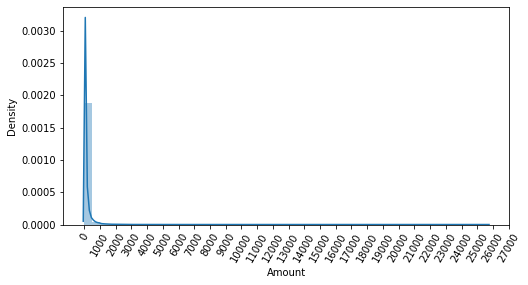

In [11]:
import seaborn as sns
plt.figure(figsize = (8, 4))
plt.xticks(range(0 ,30000, 1000), rotation = 60)
sns.distplot(card_df['Amount'])

# Amount 즉 카드 사용금액이 1000불 이하인 데이터가 대부분임


In [12]:
# Amount를 표준 정규 분포 형태로 변환한 뒤에 로지스틱 회귀의 예측 성능을 예측해보겠다.

# 중요한것은 로지스틱 회귀는 선형모델이기 때문에, 피처값들이 정규 분포 형태를 유지하는것을 선호한다.

from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처 값 변환하는 로직으로 수정
def get_preprocessed_df(df = None):
  df_copy = df.copy()
  scaler = StandardScaler()
  amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))

  # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 칼럼으로 입력
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
  return df_copy

In [13]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스팃 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

### 로지스팃 회귀 예측 성능 ###
오차행렬
[[85281    14]
 [   58    90]]
정확도:0.9991573329588147, 정밀도:0.8653846153846154, 재현율:0.6081081081081081, F1:0.7142857142857144, AUC:0.9702267805058122
### LightGBM 예측 성능 ###
오차행렬
[[85289     6]
 [   36   112]]
정확도:0.9995084442259752, 정밀도:0.9491525423728814, 재현율:0.7567567567567568, F1:0.8421052631578948, AUC:0.9772904213199659


In [14]:
# 이번에는 StandardScaler가 아니라 로그변환을 수행해보겠다. 로그 변환은 데이터 분포도가 심하게
# 왜곡되어 있을 경우 적용하는 중요 기법중 하나이다.

def get_preprocessed_df(df = None):
  df_copy = df.copy()

  # 넘파이의 log1p()를 이용해 Amount를 로그 변환
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scalerd', amount_n)
  df_copy.drop(["Time", "Amount"], axis = 1, inplace = True)
  return df_copy

In [15]:
# 이제 Amount 피처를 로그 변환후 다시 로지스틱과 LightGBM모델을 적용후 예측 성능 확인

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스팃 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

# 두 모델 모두 정밀도, 재현율 ROC AUC에서 약간씩 성능이 개선되었음을 알 수 있다.

### 로지스팃 회귀 예측 성능 ###
오차행렬
[[85283    12]
 [   59    89]]
정확도:0.99916903666772, 정밀도:0.8811881188118812, 재현율:0.6013513513513513, F1:0.714859437751004, AUC:0.9726832788589045
### LightGBM 예측 성능 ###
오차행렬
[[85290     5]
 [   35   113]]
정확도:0.9995318516437859, 정밀도:0.9576271186440678, 재현율:0.7635135135135135, F1:0.849624060150376, AUC:0.9785520997872249


## 이상치 데이터 제거 후 모델 학습/예측/평가

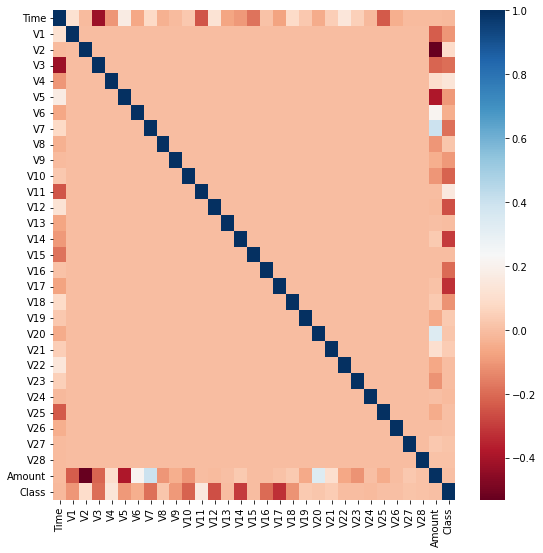

In [16]:
import seaborn as sns
plt.figure(figsize = (9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap = 'RdBu')

In [17]:
import numpy as np

def get_outlier(df = None, column = None, weight = 1.5):
  # fraud에 해당하는 column 데이터만 추출, 1/4분위와 3/4분위 지점을 np.percentile로 구함
  fraud = df[df['Class'] == 1][column]
  quantile_25 = np.percentile(fraud.values, 25)
  quantile_75 = np.percentile(fraud.values, 75)
  # IQR을 구하고, IQR 1.5를 곱해 최댓값과 최솟값 지점 구함.
  iqr = quantile_75 - quantile_25
  iqr_weight = iqr * weight
  lowest_val = quantile_25 - iqr_weight
  highest_val = quantile_75 + iqr_weight
  # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환.
  outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
  return outlier_index

In [19]:
outlier_index = get_outlier(df = card_df, column = 'V14', weight = 1.5)
print('이상치 데이터 인덱스:', outlier_index)

# 총 4개의 데이터인 8296, 8615, 9035, 9252번 index가 이상치로 추출됐다.
# get_outlier()를 이용해 이상치를 추출하고, 이를 삭제하는 로직을 get_processed_df() 함수에 추가해
# 데이터를 가공한 뒤 이 데이터를 로지스틱과 LightGBM모델을 다시 적용해보겠다.

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [27]:
# get_processed_df()를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경

def get_preprocessed_df(df = None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy["Amount"])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis=1, inplace = True)

  # 이상치 데이터 삭제하는 로직 추가
  outlier_index = get_outlier(df=df_copy, column = 'V14', weight = 1.5)
  df_copy.drop(outlier_index, axis = 0, inplace = True)
  return df_copy

In [28]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print("### 로지스틱 회귀의 성능 ###")
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

# 이상치 데이터를 제거한 뒤, 로지스틱 회귀와 라잇쥐비엠 모두 예측 성능 크게 향상
# 로지스틱경우 재현율이 60 -> 67%로, 라잇쥐비엠도 76 -> 82로 증가

### 로지스틱 회귀의 성능 ###
오차행렬
[[85281    14]
 [   48    98]]
정확도:0.9992743530623471, 정밀도:0.875, 재현율:0.6712328767123288, F1:0.7596899224806201, AUC:0.9742723681790916
### LightGBM 예측 성능 ###
오차행렬
[[85291     4]
 [   25   121]]
정확도:0.9996605844969043, 정밀도:0.968, 재현율:0.8287671232876712, F1:0.8929889298892988, AUC:0.9830703593571706
